# NFT Music Price Predication: AdaBoost and RandomForest Model

In [3]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split


## Dataset

In [4]:
# Load dataset
df = pd.read_csv('data\\Training_dataset_Cleaned_all_phasses_updated.csv')
df.head()

,CONTRACT_ADDRESS,TOKEN_ID,NFT_FIRST_PRICE,NFT_LAST_PRICE,NFT_AVG_PRICE,NFT_SALE_COUNT,COLLECTION_AVG_PRICE,COLLECTION_CEILING_PRICE,TOTAL_VOLUME_USD,CURRENT_OWNER,OWNER_TOTAL_PURCHASES,OWNER_DIVERSE_COLLECTIONS,OWNER_AVG_PURCHASE_PRICE,LAST_SALE_TIME_FORMATTED
0,0xfb3765e0e7ac73e736566af913fa58c3cfd686b7,9881.0,4.978197,4.978197,4.978197,1.0,117825.0196,577302.976,376804412.7,0x34f5c36dfd35ef66c996eca754bc5e38165f31f4,9.0,3.0,8.049071,21/04/2025 18:34
1,0xfb3765e0e7ac73e736566af913fa58c3cfd686b7,7687.0,10.324640,12.707920,9.362174,3.0,117825.0196,577302.976,376804412.7,0xfda9c682976945df1c630b3c851947a8dd05d4c9,1.0,1.0,12.707920,20/04/2025 23:29
2,0xfb3765e0e7ac73e736566af913fa58c3cfd686b7,1028.0,4.990473,4.990473,4.990473,1.0,117825.0196,577302.976,376804412.7,0x34f5c36dfd35ef66c996eca754bc5e38165f31f4,9.0,3.0,8.049071,17/04/2025 18:13
3,0xfb3765e0e7ac73e736566af913fa58c3cfd686b7,1030.0,4.990473,4.990473,4.990473,1.0,117825.0196,577302.976,376804412.7,0x34f5c36dfd35ef66c996eca754bc5e38165f31f4,9.0,3.0,8.049071,17/04/2025 18:13
4,0xfb3765e0e7ac73e736566af913fa58c3cfd686b7,1033.0,4.990473,4.990473,4.990473,1.0,117825.0196,577302.976,376804412.7,0x34f5c36dfd35ef66c996eca754bc5e38165f31f4,9.0,3.0,8.049071,17/04/2025 18:13


In [5]:
# Keep all columns, drop only missing rows
df_full = df.dropna()

## Normalization

In [6]:
# Calculate mean and standard deviation for numeric columns
mean_values = df.mean(numeric_only=True)
std_values = df.std(numeric_only=True)
print('Mean of features:\n', mean_values)
print('\nStandard Deviation of features:\n', std_values)

Mean of features:
 TOKEN_ID                     5.211273e+03
NFT_FIRST_PRICE              5.649347e+02
NFT_LAST_PRICE               3.631315e+02
NFT_AVG_PRICE                5.702055e+02
NFT_SALE_COUNT               2.687000e+00
COLLECTION_AVG_PRICE         7.029657e+04
COLLECTION_CEILING_PRICE     3.722846e+05
TOTAL_VOLUME_USD             2.310725e+08
OWNER_TOTAL_PURCHASES        4.204767e+01
OWNER_DIVERSE_COLLECTIONS    1.376667e+00
OWNER_AVG_PURCHASE_PRICE     5.322567e+02
dtype: float64

Standard Deviation of features:
 TOKEN_ID                     2.960842e+03
NFT_FIRST_PRICE              8.899504e+02
NFT_LAST_PRICE               8.746961e+03
NFT_AVG_PRICE                9.344909e+03
NFT_SALE_COUNT               1.353039e+01
COLLECTION_AVG_PRICE         5.741907e+04
COLLECTION_CEILING_PRICE     2.476824e+05
TOTAL_VOLUME_USD             1.760585e+08
OWNER_TOTAL_PURCHASES        5.580874e+01
OWNER_DIVERSE_COLLECTIONS    1.256177e+00
OWNER_AVG_PURCHASE_PRICE     1.182422e+04
dtype: f

## Formatting

In [7]:
# Convert LAST_SALE_TIME_FORMATTED to datetime and extract features
df_full['LAST_SALE_TIME_FORMATTED'] = pd.to_datetime(df_full['LAST_SALE_TIME_FORMATTED'], format='%d/%m/%Y %H:%M')

# Extract useful time-based features
df_full['SALE_HOUR'] = df_full['LAST_SALE_TIME_FORMATTED'].dt.hour
df_full['SALE_DAY'] = df_full['LAST_SALE_TIME_FORMATTED'].dt.day
df_full['SALE_MONTH'] = df_full['LAST_SALE_TIME_FORMATTED'].dt.month

# Drop the original datetime string column
df_full.drop(columns=['LAST_SALE_TIME_FORMATTED'], inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_14188\314724941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['LAST_SALE_TIME_FORMATTED'] = pd.to_datetime(df_full['LAST_SALE_TIME_FORMATTED'], format='%d/%m/%Y %H:%M')
C:\Users\HP\AppData\Local\Temp\ipykernel_14188\314724941.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['SALE_HOUR'] = df_full['LAST_SALE_TIME_FORMATTED'].dt.hour
C:\Users\HP\AppData\Local\Temp\ipykernel_14188\314724941.py:6: SettingWithCopyWarning: 
A value is trying to be 

In [8]:
# Label Encoding for string columns
from sklearn.preprocessing import LabelEncoder

# Columns to encode
label_encoders = {}
for col in ['CONTRACT_ADDRESS', 'CURRENT_OWNER']:
    le = LabelEncoder()
    df_full[col] = le.fit_transform(df_full[col])
    label_encoders[col] = le

C:\Users\HP\AppData\Local\Temp\ipykernel_14188\715891046.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full[col] = le.fit_transform(df_full[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_14188\715891046.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full[col] = le.fit_transform(df_full[col])


## Target Value: Nft last price

In [9]:
# Set up features and target (keeping all columns)
X = df_full.drop(columns=['NFT_LAST_PRICE'])
y = df_full['NFT_LAST_PRICE']

## Splitting data into training and testing

In [10]:
# Train-test split (60% training, 40% testing)
X = df_full.drop(columns=['NFT_LAST_PRICE'])
y = df_full['NFT_LAST_PRICE']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train.shape, X_test.shape

((1800, 15), (1200, 15))

## Cross Validation

In [11]:
# Cross-validation for model evaluation
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)

# Perform 5-fold cross-validation on the training data
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
ada_scores = cross_val_score(ada_model, X_train, y_train, cv=5, scoring='r2')

print('Random Forest CV R² scores:', rf_scores)
print('Random Forest Mean R²:', rf_scores.mean())
print('\nAdaBoost CV R² scores:', ada_scores)
print('AdaBoost Mean R²:', ada_scores.mean())

Random Forest CV R² scores: [0.3161698  0.91155642 0.04604589 0.9264504  0.85682404]
Random Forest Mean R²: 0.6114093104571054

AdaBoost CV R² scores: [0.14733063 0.96271927 0.03000129 0.93278276 0.54352441]
AdaBoost Mean R²: 0.5232716730725577


# Using Regression:
## Phase 1: NFT information

In [12]:
# Phase 1: Regression using normalized NFT_LAST_PRICE

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Define features and target for Phase 1
phase1_features = ['TOKEN_ID', 'NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT']
phase1_target = 'NFT_LAST_PRICE'

# Prepare the data
X_phase1 = df_full[phase1_features]
y_phase1 = df_full[phase1_target]

# Normalize the target variable to range [0, 1]
scaler = MinMaxScaler()
y_phase1_scaled = scaler.fit_transform(y_phase1.values.reshape(-1, 1)).ravel()

# Split the data into training and testing sets (60/40)
X_train_p1, X_test_p1, y_train_p1, y_test_p1 = train_test_split(X_phase1, y_phase1_scaled, test_size=0.4, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)

# Train models
rf_model.fit(X_train_p1, y_train_p1)
ada_model.fit(X_train_p1, y_train_p1)

# Predict on test set
rf_preds = rf_model.predict(X_test_p1)
ada_preds = ada_model.predict(X_test_p1)

# Evaluation metrics function
def evaluate_model(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Evaluate both models
rf_metrics = evaluate_model(y_test_p1, rf_preds)
ada_metrics = evaluate_model(y_test_p1, ada_preds)

# Combine and display metrics
metrics_df = pd.DataFrame([rf_metrics, ada_metrics], index=["Random Forest (Scaled)", "AdaBoost (Scaled)"])
print(metrics_df)


                            RMSE       MAE        R2
Random Forest (Scaled)  0.000469  0.000105  0.929503
AdaBoost (Scaled)       0.000829  0.000550  0.779673


## Phase 2: Nft information and its collection information

In [13]:
# Phase 2: Regression using NFT + Collection Information

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import pandas as pd

# Evaluation function
def evaluate_model(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Select features and target for Phase 2
phase2_features = [
    'TOKEN_ID', 'NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT',
    'CONTRACT_ADDRESS', 'COLLECTION_AVG_PRICE', 'COLLECTION_CEILING_PRICE', 'TOTAL_VOLUME_USD'
]
phase2_target = 'NFT_LAST_PRICE'

# Prepare input features and target
X_phase2 = df_full[phase2_features].copy()
y_phase2 = df_full[phase2_target]

# Label encode CONTRACT_ADDRESS (string -> numeric)
label_encoder_contract = LabelEncoder()
X_phase2['CONTRACT_ADDRESS'] = label_encoder_contract.fit_transform(X_phase2['CONTRACT_ADDRESS'])

# Normalize the target variable to range [0, 1]
scaler = MinMaxScaler()
y_phase2_scaled = scaler.fit_transform(y_phase2.values.reshape(-1, 1)).ravel()

# Split into training and testing sets (60/40 split)
X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(X_phase2, y_phase2_scaled, test_size=0.4, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)

# Train the models
rf_model.fit(X_train_p2, y_train_p2)
ada_model.fit(X_train_p2, y_train_p2)

# Predict using the trained models
rf_preds = rf_model.predict(X_test_p2)
ada_preds = ada_model.predict(X_test_p2)

# Evaluate model performance
rf_metrics = evaluate_model(y_test_p2, rf_preds)
ada_metrics = evaluate_model(y_test_p2, ada_preds)

# Display results
metrics_df = pd.DataFrame([rf_metrics, ada_metrics], index=["Random Forest (Phase 2)", "AdaBoost (Phase 2)"])
print(metrics_df)


                             RMSE       MAE        R2
Random Forest (Phase 2)  0.000441  0.000096  0.937549
AdaBoost (Phase 2)       0.000808  0.000544  0.790611


## Phase 3: NFT and its owner information

In [14]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
import numpy as np

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Phase 3 features (excluding TOKEN_ID and CURRENT_OWNER)
phase3_features = [
    'NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT',
    'OWNER_TOTAL_PURCHASES', 'OWNER_DIVERSE_COLLECTIONS',
    'OWNER_AVG_PURCHASE_PRICE', 'SALE_HOUR', 'SALE_DAY', 'SALE_MONTH'
]
phase3_target = 'NFT_LAST_PRICE'

# Prepare feature set
X_phase3 = df_full[phase3_features].copy()
y_phase3 = df_full[phase3_target]

# Normalize the target
scaler = MinMaxScaler()
y_phase3_scaled = scaler.fit_transform(y_phase3.values.reshape(-1, 1)).ravel()

# Split into training and testing sets (60/40)
X_train, X_test, y_train, y_test = train_test_split(X_phase3, y_phase3_scaled, test_size=0.4, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)

# Train models
rf_model.fit(X_train, y_train)
ada_model.fit(X_train, y_train)

# Predict on test set
rf_preds = rf_model.predict(X_test)
ada_preds = ada_model.predict(X_test)

# Evaluate models
rf_metrics = evaluate_model(y_test, rf_preds)
ada_metrics = evaluate_model(y_test, ada_preds)

# Display results
metrics_df = pd.DataFrame([rf_metrics, ada_metrics], index=["Random Forest (Phase 3)", "AdaBoost (Phase 3)"])
print("Phase 3 Evaluation Metrics:\n", metrics_df)

# Feature importance for Random Forest
rf_importance = pd.DataFrame({
    "Feature": X_phase3.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importances (Phase 3):\n", rf_importance)


Phase 3 Evaluation Metrics:
                              RMSE       MAE        R2
Random Forest (Phase 3)  0.002794  0.000139 -1.504855
AdaBoost (Phase 3)       0.000457  0.000307  0.932839

Random Forest Feature Importances (Phase 3):
                      Feature  Importance
1              NFT_AVG_PRICE    0.410114
2             NFT_SALE_COUNT    0.312010
5   OWNER_AVG_PURCHASE_PRICE    0.176927
0            NFT_FIRST_PRICE    0.075268
8                 SALE_MONTH    0.015809
7                   SALE_DAY    0.006694
6                  SALE_HOUR    0.002232
3      OWNER_TOTAL_PURCHASES    0.000720
4  OWNER_DIVERSE_COLLECTIONS    0.000225


## Phase 4: NFT, its collection and owner information

In [15]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
import numpy as np

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Define Phase 4 features (NFT + Collection + Owner Info)
phase4_features = [
    'NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT',  # Phase 1
    'CONTRACT_ADDRESS', 'COLLECTION_AVG_PRICE', 'COLLECTION_CEILING_PRICE', 'TOTAL_VOLUME_USD',  # Phase 2
    'OWNER_TOTAL_PURCHASES', 'OWNER_DIVERSE_COLLECTIONS', 'OWNER_AVG_PURCHASE_PRICE',  # Phase 3
    'SALE_HOUR', 'SALE_DAY', 'SALE_MONTH'  # Extracted from date
]

phase4_target = 'NFT_LAST_PRICE'

# Prepare feature set
X_phase4 = df_full[phase4_features].copy()
y_phase4 = df_full[phase4_target]

# Label encode CONTRACT_ADDRESS
label_encoder = LabelEncoder()
X_phase4['CONTRACT_ADDRESS'] = label_encoder.fit_transform(X_phase4['CONTRACT_ADDRESS'])

# Normalize the target variable
scaler = MinMaxScaler()
y_phase4_scaled = scaler.fit_transform(y_phase4.values.reshape(-1, 1)).ravel()

# Train-test split (60/40)
X_train, X_test, y_train, y_test = train_test_split(X_phase4, y_phase4_scaled, test_size=0.4, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)

# Train models
rf_model.fit(X_train, y_train)
ada_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)
ada_preds = ada_model.predict(X_test)

# Evaluate
rf_metrics = evaluate_model(y_test, rf_preds)
ada_metrics = evaluate_model(y_test, ada_preds)

# Combine results into a DataFrame
metrics_df = pd.DataFrame([rf_metrics, ada_metrics], index=["Random Forest (Phase 4)", "AdaBoost (Phase 4)"])
print("Phase 4 Evaluation Metrics:\n", metrics_df)


Phase 4 Evaluation Metrics:
                              RMSE       MAE        R2
Random Forest (Phase 4)  0.002496  0.000129 -0.999459
AdaBoost (Phase 4)       0.000478  0.000337  0.926682


## Predication on Training and testing data

In [16]:
# Predict on training and testing data
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

ada_train_preds = ada_model.predict(X_train)
ada_test_preds = ada_model.predict(X_test)

# Evaluate both sets
rf_train_metrics = evaluate_model(y_train, rf_train_preds)
rf_test_metrics = evaluate_model(y_test, rf_test_preds)

ada_train_metrics = evaluate_model(y_train, ada_train_preds)
ada_test_metrics = evaluate_model(y_test, ada_test_preds)

# Combine into one DataFrame
results = pd.DataFrame({
    'Model': ['Random Forest', 'Random Forest', 'AdaBoost', 'AdaBoost'],
    'Set': ['Train', 'Test', 'Train', 'Test'],
    'RMSE': [rf_train_metrics['RMSE'], rf_test_metrics['RMSE'], ada_train_metrics['RMSE'], ada_test_metrics['RMSE']],
    'MAE': [rf_train_metrics['MAE'], rf_test_metrics['MAE'], ada_train_metrics['MAE'], ada_test_metrics['MAE']],
    'R2': [rf_train_metrics['R2'], rf_test_metrics['R2'], ada_train_metrics['R2'], ada_test_metrics['R2']]
})

print("Phase 4 - Train/Test Evaluation Metrics:\n", results)


Phase 4 - Train/Test Evaluation Metrics:
            Model    Set      RMSE       MAE        R2
0  Random Forest  Train  0.008943  0.000244  0.856477
1  Random Forest   Test  0.002496  0.000129 -0.999459
2       AdaBoost  Train  0.000474  0.000340  0.999597
3       AdaBoost   Test  0.000478  0.000337  0.926682


# Using Classification on Phase 4

In [17]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Function to evaluate classification model performance
def classification_metrics(y_true, y_pred, y_proba):
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred)
    }

# Use combined features from Phase 4 (NFT + Collection + Owner)
phase4_features = [
    'NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT',
    'CONTRACT_ADDRESS', 'COLLECTION_AVG_PRICE', 'COLLECTION_CEILING_PRICE', 'TOTAL_VOLUME_USD',
    'OWNER_TOTAL_PURCHASES', 'OWNER_DIVERSE_COLLECTIONS', 'OWNER_AVG_PURCHASE_PRICE',
    'SALE_HOUR', 'SALE_DAY', 'SALE_MONTH'
]

# Classification target: Convert `NFT_LAST_PRICE` into a binary label based on median
phase4_target = 'NFT_LAST_PRICE'
y_class = (df_full[phase4_target] >= df_full[phase4_target].median()).astype(int)

# Prepare feature data
X_classification = df_full[phase4_features].copy()
label_encoder = LabelEncoder()
X_classification['CONTRACT_ADDRESS'] = label_encoder.fit_transform(X_classification['CONTRACT_ADDRESS'])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_class, test_size=0.4, random_state=42)

# Initialize classifiers
rf_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

# Train classifiers
rf_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

# Predictions and probabilities
rf_preds = rf_clf.predict(X_test)
ada_preds = ada_clf.predict(X_test)
rf_probs = rf_clf.predict_proba(X_test)[:, 1]
ada_probs = ada_clf.predict_proba(X_test)[:, 1]

# Evaluate models
rf_metrics = classification_metrics(y_test, rf_preds, rf_probs)
ada_metrics = classification_metrics(y_test, ada_preds, ada_probs)

# Create results DataFrame
metrics_df = pd.DataFrame([rf_metrics, ada_metrics], index=["Random Forest (Class)", "AdaBoost (Class)"])
print("Phase 4 Classification Metrics:\n", metrics_df)


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Phase 4 Classification Metrics:
                             AUC        F1  Precision    Recall
Random Forest (Class)  0.987660  0.932766   0.936752  0.928814
AdaBoost (Class)       0.973984  0.926789   0.910131  0.944068


## Classification Plotting

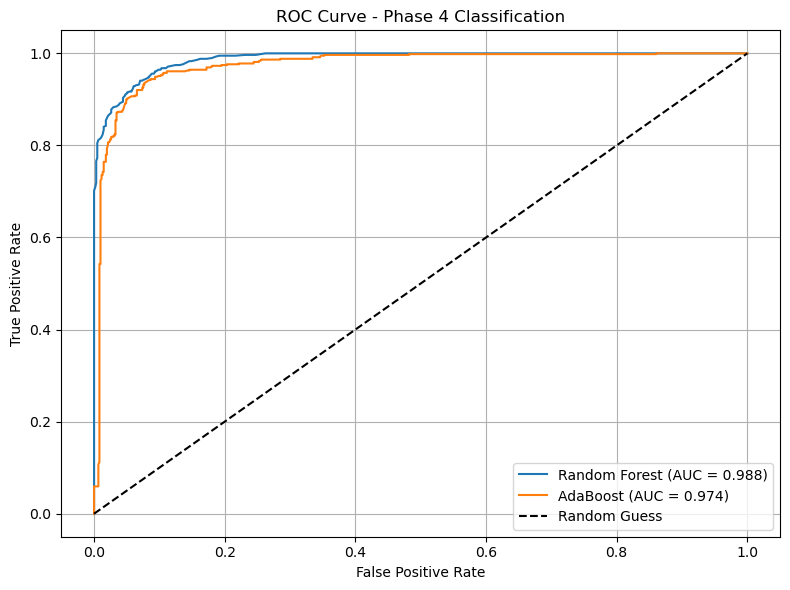

In [18]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve values for both models
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.3f})'.format(roc_auc_score(y_test, rf_probs)))
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (AUC = {:.3f})'.format(roc_auc_score(y_test, ada_probs)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal reference line

# Labels and styling
plt.title('ROC Curve - Phase 4 Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Results of All Four Phases using regression

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_csv('data\\Training_dataset_Cleaned_all_phasses_updated.csv')
df = df.dropna()
df['LAST_SALE_TIME_FORMATTED'] = pd.to_datetime(df['LAST_SALE_TIME_FORMATTED'], format='%d/%m/%Y %H:%M')
df['SALE_HOUR'] = df['LAST_SALE_TIME_FORMATTED'].dt.hour
df['SALE_DAY'] = df['LAST_SALE_TIME_FORMATTED'].dt.day
df['SALE_MONTH'] = df['LAST_SALE_TIME_FORMATTED'].dt.month
df.drop(columns=['LAST_SALE_TIME_FORMATTED'], inplace=True)
df['CONTRACT_ADDRESS'] = LabelEncoder().fit_transform(df['CONTRACT_ADDRESS'])
df['CURRENT_OWNER'] = LabelEncoder().fit_transform(df['CURRENT_OWNER'])

def evaluate_model(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

phases = {
    "Phase 1": ['TOKEN_ID', 'NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT'],
    "Phase 2": ['TOKEN_ID', 'NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT',
                'CONTRACT_ADDRESS', 'COLLECTION_AVG_PRICE', 'COLLECTION_CEILING_PRICE', 'TOTAL_VOLUME_USD'],
    "Phase 3": ['NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT',
                'OWNER_TOTAL_PURCHASES', 'OWNER_DIVERSE_COLLECTIONS',
                'OWNER_AVG_PURCHASE_PRICE', 'SALE_HOUR', 'SALE_DAY', 'SALE_MONTH'],
    "Phase 4": ['NFT_FIRST_PRICE', 'NFT_AVG_PRICE', 'NFT_SALE_COUNT',
                'CONTRACT_ADDRESS', 'COLLECTION_AVG_PRICE', 'COLLECTION_CEILING_PRICE', 'TOTAL_VOLUME_USD',
                'OWNER_TOTAL_PURCHASES', 'OWNER_DIVERSE_COLLECTIONS', 'OWNER_AVG_PURCHASE_PRICE',
                'SALE_HOUR', 'SALE_DAY', 'SALE_MONTH']
}

scaler = MinMaxScaler()
results = []

for phase_name, features in phases.items():
    X = df[features].copy()
    y = df['NFT_LAST_PRICE']
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.4, random_state=42)

    for model_name, model in [('Random Forest', RandomForestRegressor(random_state=42)),
                              ('AdaBoost', AdaBoostRegressor(random_state=42))]:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        metrics = evaluate_model(y_test, preds)
        results.append({
            'Phase': phase_name,
            'Model': model_name,
            **metrics
        })

metrics_df = pd.DataFrame(results)
metrics_df


,Phase,Model,RMSE,MAE,R2
0,Phase 1,Random Forest,0.000469,0.000105,0.929503
1,Phase 1,AdaBoost,0.000829,0.000550,0.779673
2,Phase 2,Random Forest,0.000441,0.000096,0.937549
3,Phase 2,AdaBoost,0.000808,0.000544,0.790611
4,Phase 3,Random Forest,0.002794,0.000139,-1.504855
5,Phase 3,AdaBoost,0.000457,0.000307,0.932839
6,Phase 4,Random Forest,0.002496,0.000129,-0.999459
7,Phase 4,AdaBoost,0.000478,0.000337,0.926682


## Graphs and Plotting for Regression

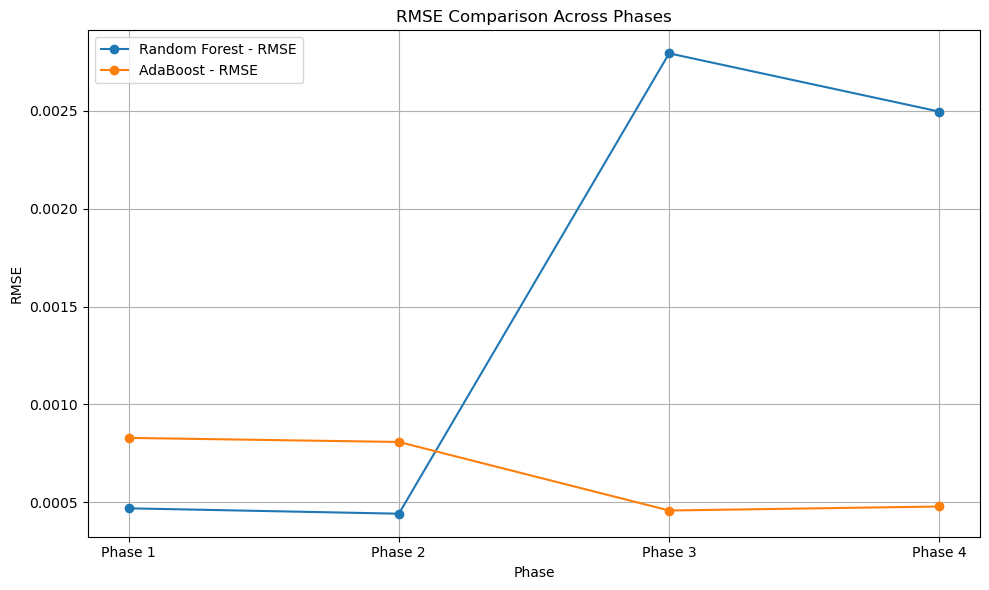

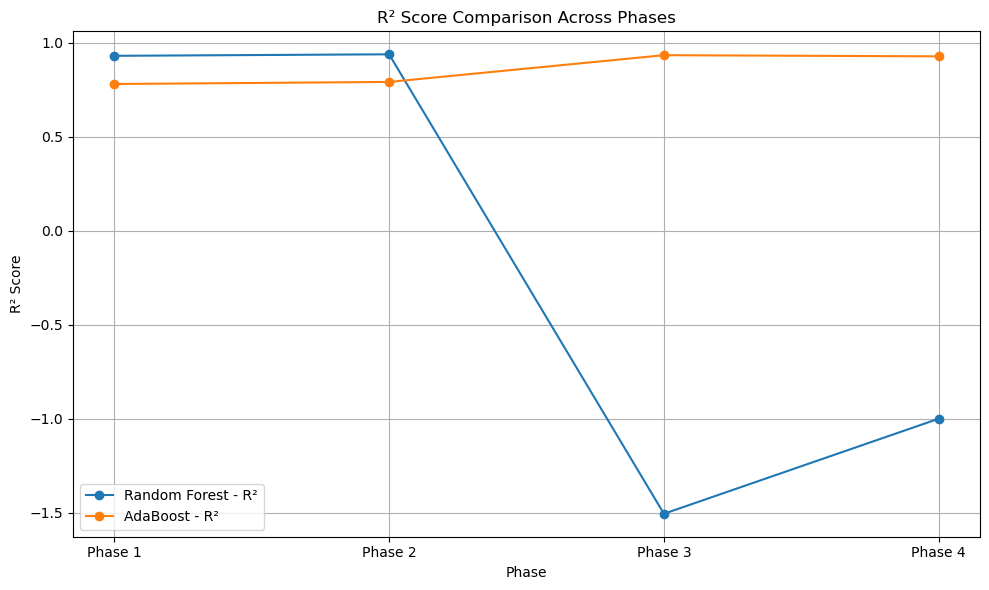

In [20]:
# Plot RMSE comparison
plt.figure(figsize=(10, 6))
for model in metrics_df['Model'].unique():
    subset = metrics_df[metrics_df['Model'] == model]
    plt.plot(subset['Phase'], subset['RMSE'], marker='o', label=f'{model} - RMSE')

plt.title('RMSE Comparison Across Phases')
plt.xlabel('Phase')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot R2 comparison
plt.figure(figsize=(10, 6))
for model in metrics_df['Model'].unique():
    subset = metrics_df[metrics_df['Model'] == model]
    plt.plot(subset['Phase'], subset['R2'], marker='o', label=f'{model} - R²')

plt.title('R² Score Comparison Across Phases')
plt.xlabel('Phase')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
